We will use the [Variational Autoencoder](https://arxiv.org/abs/1312.6114), but slightly modified to suit our needs.

Note: you will find a lot of functions `fn()`. These functions are just meant to test if the code written is working as it should. I put the testing code inside these functions as I didn't want to waste the namespace.

In [1]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import torchinfo
from torchinfo import summary

from tensorflow.keras import datasets

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import pytz
from datetime import datetime
import time
import copy
# import glob
# import joblib
# import albumentations

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
# import seaborn as sns
# plt.style.use("fivethirtyeight")
# plt.style.use("default")

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline
# %config InlineBackend.figure_format="svg"

print("Imports done!")

2024-03-16 00:05:27.790387: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 00:05:27.790483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 00:05:27.914505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imports done!


In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## Load and Preprocess the data

In [3]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5,
                                                    shuffle=True, stratify=y_test,
                                                    random_state=42)

In [6]:
print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape,
      y_valid.shape, y_test.shape, sep='\n')

(60000, 32, 32, 1)
(5000, 32, 32, 1)
(5000, 32, 32, 1)
(60000,)
(5000,)
(5000,)


In [7]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

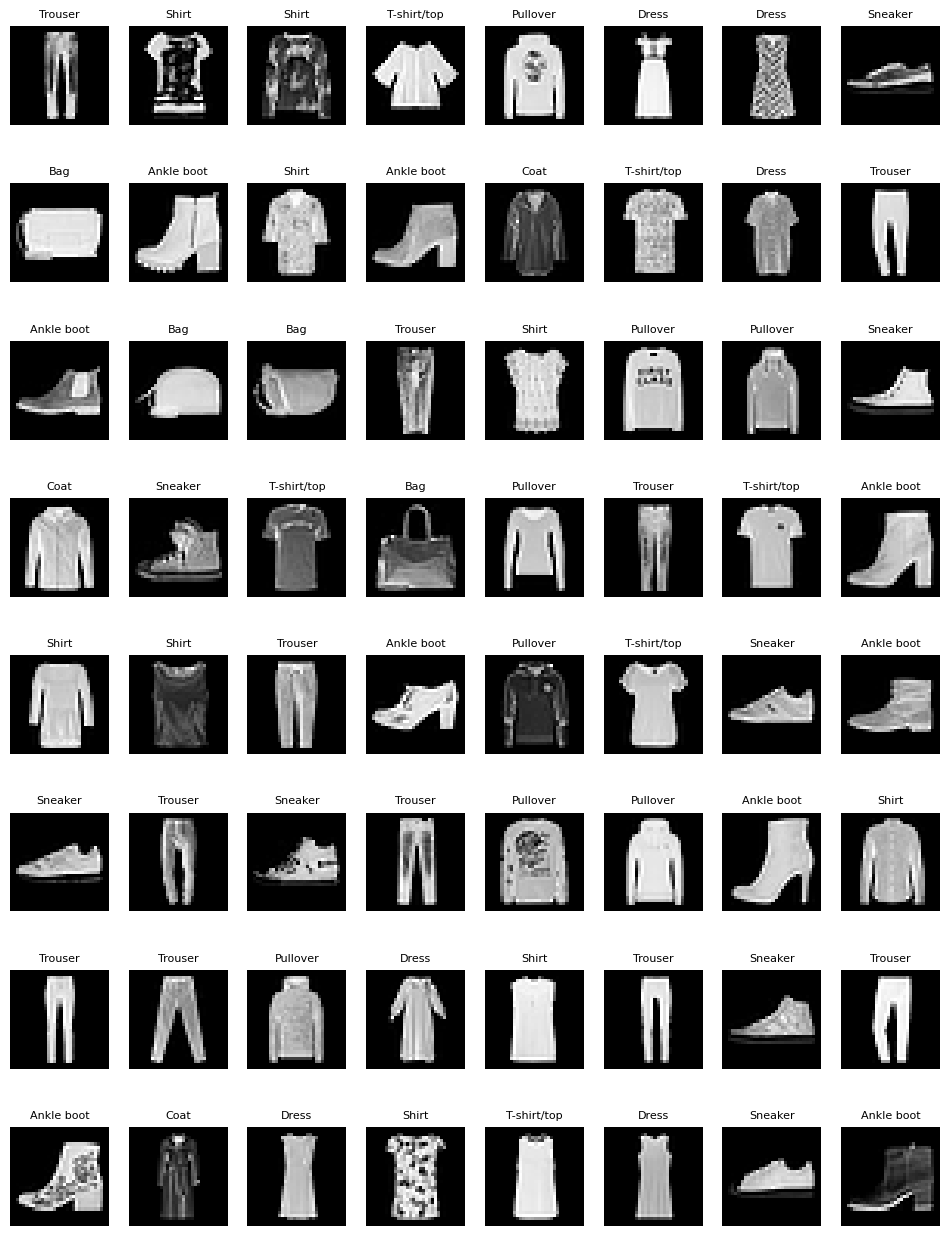

In [8]:
np.random.seed(42)

def visualize_data():
    nrows = 8
    ncols = 8
    indices = np.random.randint(low=0, high=60000, size=nrows*ncols).reshape(nrows,ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img = x_train[idx]
            label = class_labels[y_train[idx]]
            ax[i,j].imshow(img, cmap="gray")
            ax[i,j].set_title(label, fontsize=8)
            ax[i,j].axis("off")


visualize_data()

## PyTorch Model

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [10]:
class CustomDataset(Dataset):
    def __init__(self, features, targets, augmentations=None):
        self.features = features
        self.targets = targets
        self.augmentations = augmentations

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx, :]
        image = torch.tensor(image, dtype=torch.float32)
        label = self.targets[idx]
        label = torch.tensor(label, dtype=torch.long)
        if self.augmentations is not None:
            image = self.augmentations(image)
        return image, label


In [11]:
train_dataset = CustomDataset(features=x_train.reshape(60000, 1, 32, 32), targets=y_train)
valid_dataset = CustomDataset(features=x_valid.reshape(5000, 1, 32, 32), targets=y_valid)
test_dataset = CustomDataset(features=x_test.reshape(5000, 1, 32, 32), targets=y_test)

In [12]:

"""Helpful utility functions for PyTorch models."""


def set_dataloaders(batch_size=32):
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
                              # drop_last=True  # this will drop the last batch if its size is not 32
                              # pin_memory=True,
                              # num_workers=os.cpu_count())
    val_loader = DataLoader(valid_dataset,
                            batch_size=batch_size,
                            shuffle=False)
                            # drop_last=True  # this will drop the last batch if its size is not 32
                            # pin_memory=True,
                            # num_workers=os.cpu_count())
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
                             # drop_last=True  # this will drop the last batch if its size is not 32
                             # pin_memory=True,
                             # num_workers=os.cpu_count())
    return train_loader, val_loader, test_loader


def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if version of pytorch is =< 1.7, then use torch.set_deterministic(True)
        # else use torch.use_deterministic_algorithms(True)
        torch.use_deterministic_algorithms(True)
        
        
def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc /= len(y_pred)
    return acc
    

def train_step(model, dataloader, loss_fn, optimizer, device):
    """
    Processes just one training step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the training loss and accuracy values of this entire batch to 0
    train_loss, train_acc = 0, 0
    # put the model in training mode
    model.train()
    # loop through the data loader batches
    for batch, (X, y) in enumerate(dataloader):
        # send both the X and y to device being used
        # we assume that the model is on this device already
        X = X.to(device)
        y = y.to(device)
        # forward pass
        logits = model(X)
        y_pred = torch.softmax(logits, dim=1)
        y_label = y_pred.argmax(dim=1)
        # calculate the loss and add it to the batch's training loss
        loss = loss_fn(logits, y)
        train_loss += loss.item()
        # calculate the accuracy and add it to the batch's training accuracy
        acc = compute_accuracy(y_label, y)
        train_acc += acc
        # zero the gradients of the optimizer so that they don't accumulate
        optimizer.zero_grad()
        # do a backward pass on the loss
        loss.backward()
        # update the optimizer (ie, update the gradients)
        optimizer.step()
    # calculate the average training loss and accuracy for this batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def train_step_gdl(model, dataloader, loss_fn, optimizer, device):
    """
    A variation of the original train_step function for generative deep
    learning models. Processes just one training step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the training loss value of this entire batch to 0
    train_loss = 0
    # put the model in training mode
    model.train()
    # loop through the data loader batches
    for batch, (X, _) in enumerate(dataloader):
        # we don't need y, as the model is tested on how accurately it can 
        # reproduce the original image
        # send X the to device being used
        # we assume that the model is on this device already
        X = X.to(device)
        # forward pass
        reconstructed_img = model(X)
        # calculate the loss and add it to the batch's training loss
        loss = loss_fn(reconstructed_img, X)
        train_loss += loss.item()
        # zero the gradients of the optimizer so that they don't accumulate
        optimizer.zero_grad()
        # do a backward pass on the loss
        loss.backward()
        # update the optimizer (ie, update the gradients)
        optimizer.step()
    # calculate the average training loss for this batch
    train_loss /= len(dataloader)
    return train_loss


def validation_step(model, dataloader, loss_fn, device):
    """
    Processes just one step of validation, ie, just one batch.
    To be used inside the main training function.
    """
    # initialize the validation loss and accuracy values of this entire batch to 0
    val_loss, val_acc = 0, 0
    # put the model to evaluation mode
    model.eval()
    # turn on the inference context manager
    with torch.inference_mode():
        # loop through the dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send both X and y to the device being used
            # we assume that the model is on this device already
            X = X.to(device)
            y = y.to(device)
            # forward pass
            logits = model(X)
            y_pred = torch.softmax(logits, dim=1)
            y_label = y_pred.argmax(dim=1)
            # calculate the loss and add it to the batch's validation loss
            loss = loss_fn(logits, y)
            val_loss += loss.item()
            # calculate the accuracy and add it to the batch's validation accuracy
            acc = compute_accuracy(y_label, y)
            val_acc += acc
    # calculate the average validation loss and accuracy for this batch
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc


def validation_step_gdl(model, dataloader, loss_fn, device):
    """
    A variation of the original validation_step function for generative deep
    learning models. Processes just one validation step, ie, just one batch.
    To be used inside the main the training function.
    """
    # initialize the validation loss value of this entire batch to 0
    val_loss = 0
    # put the model to evaluation mode
    model.eval()
    # turn on the inference context manager
    with torch.inference_mode():
        # loop through the dataloader batches
        for batch, (X, _) in enumerate(dataloader):
            # we don't need y, as the model is tested on how accurately it can 
            # reproduce the original image
            # send X the to device being used
            # we assume that the model is on this device already
            X = X.to(device)
            # forward pass
            reconstructed_img = model(X)
            # calculate the loss and add it to the batch's validation loss
            loss = loss_fn(reconstructed_img, X)
            val_loss += loss.item()
    # calculate the average validation loss for this batch
    val_loss /= len(dataloader)
    return val_loss


def set_scheduler(scheduler, results, scheduler_on="val_acc"):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "val_acc":
        scheduler.step(results["val_acc"][-1])
    elif scheduler_on == "val_loss":
        scheduler.step(results["val_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def training_fn(model, train_loader, val_loader, loss_fn, optimizer, 
                epochs, device, scheduler=None, scheduler_on="val_acc"):
    """The main training function."""
    # create a results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    # loop through the training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # call the training function
        train_loss, train_acc = train_step(model, train_loader, loss_fn, 
                                           optimizer, device)
        # call the validation function
        val_loss, val_acc = validation_step(model, val_loader, loss_fn, device)
        # update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        if scheduler is not None:
            # adjust the learning rate
            scheduler = set_scheduler(scheduler, results, scheduler_on)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
            f"Train_acc: {train_acc:.5f} | Val_loss: {val_loss:.5f} | "
            f"Val_acc: {val_acc:.5f}"
        )
    return results


def training_fn_gdl(model, train_loader, val_loader, loss_fn, optimizer, 
                    epochs, device, scheduler=None, scheduler_on="val_loss"):
    """
    A variation of the main training_fn function for generative deep learning models.
    """
    # create a results dictionary
    results = {
        "train_loss": [],
        "val_loss": [],
    }
    # loop through the training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # call the training function
        train_loss = train_step_gdl(model, train_loader, loss_fn, optimizer, device)
        # call the validation function
        val_loss = validation_step_gdl(model, val_loader, loss_fn, device)
        # update the results dictionary
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
        if scheduler is not None:
            # adjust the learning rate
            scheduler = set_scheduler(scheduler, results, scheduler_on)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
            f"Val_loss: {val_loss:.5f}"
        )
    return results


def save_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), PATH/model_name)
    torch.save(optimizer.state_dict(), PATH/optimizer_name)
    if scheduler is not None:
        torch.save(scheduler.state_dict(), PATH/scheduler_name)    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(PATH/model_name))
    model.to(device)
    optimizer.load_state_dict(torch.load(PATH/optimizer_name))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(PATH/scheduler_name))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


def visualize_results(results):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["val_loss"], results["val_acc"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0].plot(x, val_loss, label="val_loss", color="blue")
    ax[0].legend()
    # ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(x, train_acc, label="train_acc", color="orange")
    ax[1].plot(x, val_acc, label="val_acc", color="blue")
    ax[1].legend()
    plt.show()    
    

def visualize_results_gdl(results):
    """
    A variation of the original visualize_results function for generative deep 
    learning models. Plot the training and validation loss and accuracy, given 
    the results dictionary.
    """
    train_loss, val_loss = results["train_loss"], results["val_loss"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    plt.figure(figsize=(10,4))
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.plot(x, train_loss, label="train_loss", color="orange")
    plt.plot(x, val_loss, label="val_loss", color="blue")
    plt.legend()
    plt.show()
    
    

In [13]:
train_loader, val_loader, test_loader = set_dataloaders(128)

In [14]:
def fn():
    for X, y in train_loader:
        print(X.shape, y.shape)
        break
    pass

fn()

torch.Size([128, 1, 32, 32]) torch.Size([128])


In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=2048, out_features=2)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("After layer 1:\t", x.size())
        x = self.relu(self.conv2(x))
        # print("After layer 2:\t", x.size())
        x = self.relu(self.conv3(x))
        # print("After layer 3:\t", x.size())
        x = self.flatten(x)
        # print("After flatten:\t", x.size())
        x = self.linear1(x)
        return x
    


In [16]:
def fn():
    model = Encoder().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        model(X)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 1, 32, 32])


In [17]:
def fn():
    model = Encoder().to(DEVICE)
    return summary(model=model, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [1, 1, 32, 32]       [1, 2]               --                   True
├─Conv2d (conv1)                         [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
├─ReLU (relu)                            [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
├─Conv2d (conv2)                         [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
├─ReLU (relu)                            [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
├─Conv2d (conv3)                         [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
├─ReLU (relu)                            [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
├─Flatten (flatten)                      [1, 128, 4, 4]       [1, 2048]            --                   --
├─Linear (linear1)    

In [18]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=2048)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3),
                               stride=1, padding="same")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.linear1(x)
        # print("After linear1:\t", x.size())
        x = x.view(-1, 128, 4, 4)  # does the work of the reshape layer in tensorflow
        # print("After reshaping:", x.size())
        x = self.relu(self.convt1(x))
        # print("After convt1:\t", x.size())
        x = self.relu(self.convt2(x))
        # print("After convt2:\t", x.size())
        x = self.relu(self.convt3(x))
        # print("After convt3:\t", x.size())
        x = self.sigmoid(self.conv1(x))
        # we use sigmoid because the input images are normalized to between 0 
        # and 1 and we want the decoder to also reconstruct the images such the 
        # pixels are between 0 and 1
        # if we had normalized the images to between -1 and 1, then we would
        # have used tanh instead of sigmoid
        # print("After conv1:\t", x.size())
        return x
        

In [19]:
def fn():
    model = Decoder().to(DEVICE)
    return summary(model=model, input_size=(1,2),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [1, 2]               [1, 1, 32, 32]       --                   True
├─Linear (linear1)                       [1, 2]               [1, 2048]            6,144                True
├─ConvTranspose2d (convt1)               [1, 128, 4, 4]       [1, 128, 8, 8]       147,584              True
├─ReLU (relu)                            [1, 128, 8, 8]       [1, 128, 8, 8]       --                   --
├─ConvTranspose2d (convt2)               [1, 128, 8, 8]       [1, 64, 16, 16]      73,792               True
├─ReLU (relu)                            [1, 64, 16, 16]      [1, 64, 16, 16]      --                   --
├─ConvTranspose2d (convt3)               [1, 64, 16, 16]      [1, 32, 32, 32]      18,464               True
├─ReLU (relu)                            [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
├─Conv2d (conv1)    

In [20]:
def fn():
    encoder = Encoder().to(DEVICE)
    decoder = Decoder().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        enc_output = encoder(X)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", enc_output.shape, "---------->  embedding vector")
        decoder(enc_output)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 2]) ---------->  embedding vector


In [21]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [22]:
def fn():
    enc = Encoder().to(DEVICE)
    dec = Decoder().to(DEVICE)
    autoencoder = AutoEncoder(enc, dec).to(DEVICE)
    return summary(model=autoencoder, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AutoEncoder (AutoEncoder)                [1, 1, 32, 32]       [1, 1, 32, 32]       --                   True
├─Encoder (encoder)                      [1, 1, 32, 32]       [1, 2]               --                   True
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatten (flat

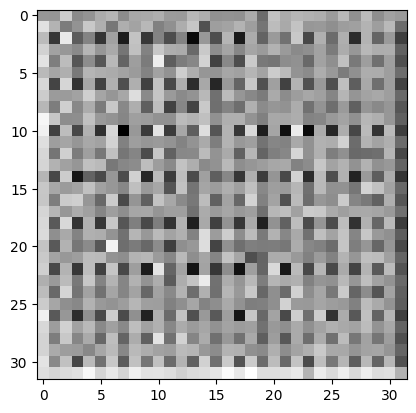

In [32]:
def fn():
    encoder = Encoder().to(DEVICE)
    decoder = Decoder().to(DEVICE)
    autoencoder = AutoEncoder(encoder, decoder).to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        output = autoencoder(X)
        if "cuda" in DEVICE:
            plt.imshow(output[0].squeeze(axis=0).cpu().detach().numpy(), cmap='gray')
        else:
            plt.imshow(output[0].squeeze(axis=0).cpu().detach().numpy(), cmap='gray')
        break
    pass

fn()

In [35]:
train_loader, val_loader, test_loader = set_dataloaders(64)

ae1 = AutoEncoder(Encoder(), Decoder()).to(DEVICE)
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=ae1.parameters(), lr=3e-4)

results = training_fn_gdl(model=ae1, train_loader=train_loader, val_loader=val_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=24, device=DEVICE)

  4%|▍         | 1/24 [00:05<02:05,  5.46s/it]

Epoch: 1 | Train_loss: 0.03903 | Val_loss: 0.02694


  8%|▊         | 2/24 [00:10<01:56,  5.31s/it]

Epoch: 2 | Train_loss: 0.02611 | Val_loss: 0.02484


 12%|█▎        | 3/24 [00:15<01:48,  5.14s/it]

Epoch: 3 | Train_loss: 0.02473 | Val_loss: 0.02398


 17%|█▋        | 4/24 [00:20<01:41,  5.07s/it]

Epoch: 4 | Train_loss: 0.02383 | Val_loss: 0.02333


 21%|██        | 5/24 [00:25<01:35,  5.05s/it]

Epoch: 5 | Train_loss: 0.02327 | Val_loss: 0.02288


 25%|██▌       | 6/24 [00:30<01:30,  5.04s/it]

Epoch: 6 | Train_loss: 0.02284 | Val_loss: 0.02261


 29%|██▉       | 7/24 [00:35<01:25,  5.02s/it]

Epoch: 7 | Train_loss: 0.02249 | Val_loss: 0.02231


 33%|███▎      | 8/24 [00:40<01:21,  5.07s/it]

Epoch: 8 | Train_loss: 0.02220 | Val_loss: 0.02215


 38%|███▊      | 9/24 [00:45<01:15,  5.05s/it]

Epoch: 9 | Train_loss: 0.02200 | Val_loss: 0.02191


 42%|████▏     | 10/24 [00:50<01:10,  5.04s/it]

Epoch: 10 | Train_loss: 0.02177 | Val_loss: 0.02185


 46%|████▌     | 11/24 [00:55<01:05,  5.03s/it]

Epoch: 11 | Train_loss: 0.02160 | Val_loss: 0.02164


 50%|█████     | 12/24 [01:00<01:00,  5.02s/it]

Epoch: 12 | Train_loss: 0.02144 | Val_loss: 0.02151


 54%|█████▍    | 13/24 [01:05<00:55,  5.02s/it]

Epoch: 13 | Train_loss: 0.02129 | Val_loss: 0.02150


 58%|█████▊    | 14/24 [01:10<00:50,  5.06s/it]

Epoch: 14 | Train_loss: 0.02113 | Val_loss: 0.02150


 62%|██████▎   | 15/24 [01:15<00:45,  5.04s/it]

Epoch: 15 | Train_loss: 0.02104 | Val_loss: 0.02129


 67%|██████▋   | 16/24 [01:20<00:40,  5.03s/it]

Epoch: 16 | Train_loss: 0.02094 | Val_loss: 0.02130


 71%|███████   | 17/24 [01:25<00:35,  5.01s/it]

Epoch: 17 | Train_loss: 0.02086 | Val_loss: 0.02107


 75%|███████▌  | 18/24 [01:30<00:29,  5.00s/it]

Epoch: 18 | Train_loss: 0.02071 | Val_loss: 0.02088


 79%|███████▉  | 19/24 [01:35<00:24,  4.99s/it]

Epoch: 19 | Train_loss: 0.02058 | Val_loss: 0.02099


 83%|████████▎ | 20/24 [01:40<00:19,  4.99s/it]

Epoch: 20 | Train_loss: 0.02052 | Val_loss: 0.02104


 88%|████████▊ | 21/24 [01:45<00:15,  5.00s/it]

Epoch: 21 | Train_loss: 0.02045 | Val_loss: 0.02082


 92%|█████████▏| 22/24 [01:50<00:10,  5.00s/it]

Epoch: 22 | Train_loss: 0.02040 | Val_loss: 0.02098


 96%|█████████▌| 23/24 [01:55<00:04,  4.99s/it]

Epoch: 23 | Train_loss: 0.02029 | Val_loss: 0.02064


100%|██████████| 24/24 [02:00<00:00,  5.03s/it]

Epoch: 24 | Train_loss: 0.02030 | Val_loss: 0.02061


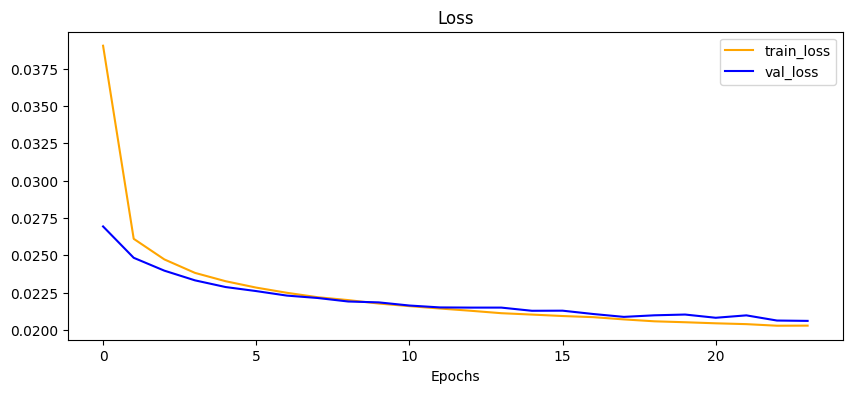

In [36]:
visualize_results_gdl(results)

## Visualizing the 2-dimensional latent space

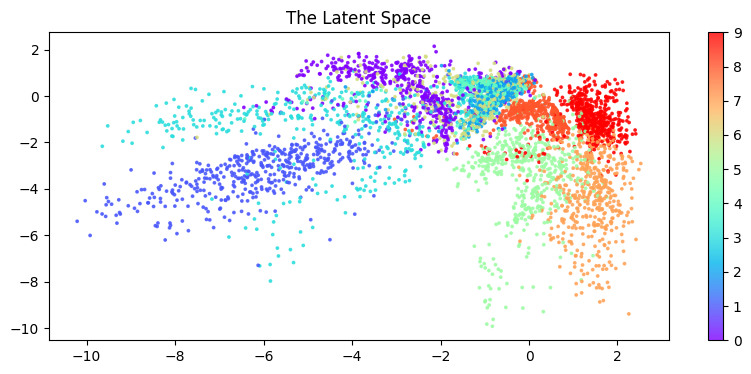

In [41]:
# Visualize the latent space

def visualize_latent_space(model, return_embeddings=False):
    embeddings = []
    labels = []
    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(DEVICE)
            preds = model.encoder(X)
            preds = preds.cpu().detach().numpy()
            embeddings.append(preds)
            labels.append(y.cpu().detach().numpy())
    last_batch_embeddings = np.array(embeddings[-1])
    embeddings.pop()
    embeddings = np.array(embeddings).reshape(-1, 2)
    last_batch_labels = np.array(labels[-1])
    labels.pop()
    labels = np.array(labels).flatten()
    if return_embeddings:
        return embeddings, labels
    else:
        plt.figure(figsize=(10,4))
        plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow", 
                    c=labels, alpha=0.8, s=3)
        plt.title("The Latent Space")
        plt.colorbar()
        plt.show()

    
visualize_latent_space(model=ae1)

## Reconstructing some images

In [44]:
def predict_torch_gdl(model, img, device):
    """
    This funtion assumes that img is a 4d tensor, ie, (N, C, H, W).
    If img is a single image, then the dimension should be (1, C, H, W).
    """
    model.eval()
    with torch.inference_mode():
        reconstructed_img = model(img)
    reconstructed_img = reconstructed_img.squeeze(dim=0)
    img = img.squeeze(dim=0)
    if "cuda" in device:
        reconstructed_img = reconstructed_img.cpu().detach().numpy().reshape(32, 32, 1)
        img = img.cpu().detach().numpy().reshape(32, 32, 1)
    else:
        reconstructed_img = reconstructed_img.detach().numpy().reshape(32, 32, 1)
        img = img.detach().numpy().reshape(32, 32, 1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].set_title("Original")
    ax[0].imshow(img, cmap="gray")
    ax[1].set_title("Reconstructed Image")
    ax[1].imshow(reconstructed_img, cmap="gray")
    plt.show()
    

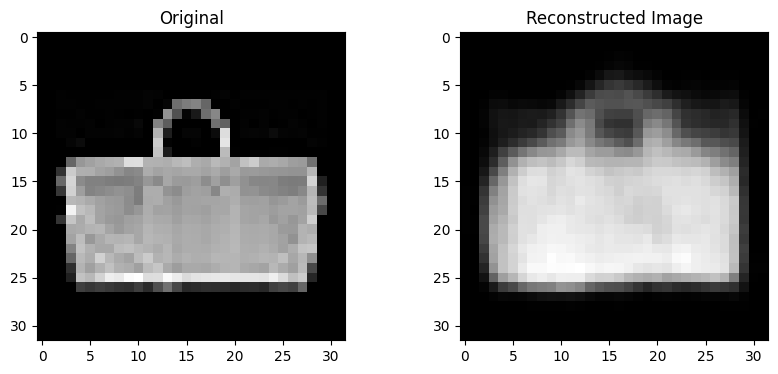

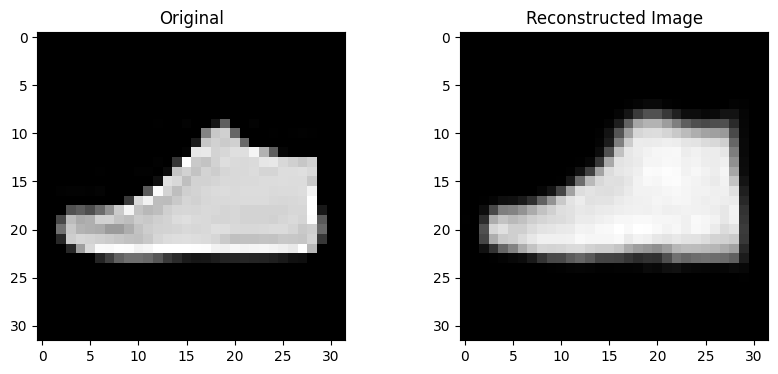

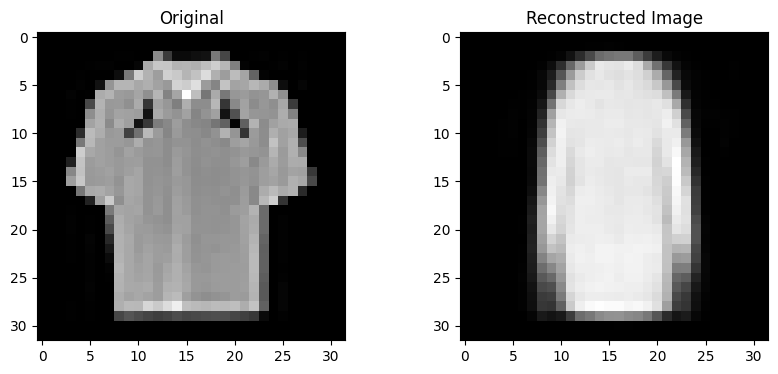

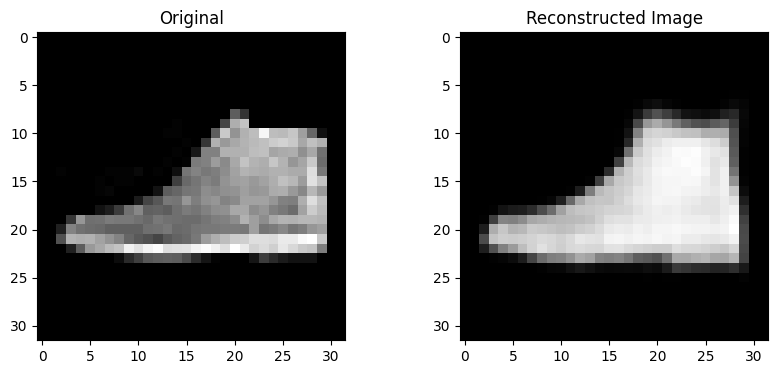

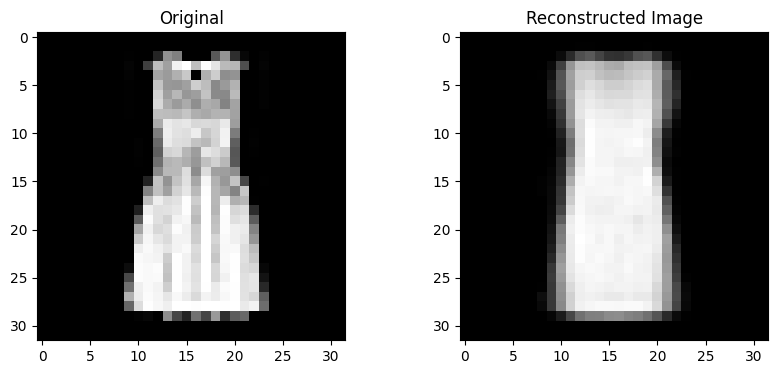

In [45]:
def fn():
    idx = 0
    for X,y in test_loader:
        if idx == 5:
            break
        X = X.to(DEVICE)
        img = X[idx].unsqueeze(dim=0)
        predict_torch_gdl(ae1, img, DEVICE)
        idx += 1
    pass

fn()

## Creating a better model (increasing the latent space to 32-dimensions)

By doing this, we are increasing the ability of the latent space to store more information.

In [46]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=2048, out_features=32)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("After layer 1:\t", x.size())
        x = self.relu(self.conv2(x))
        # print("After layer 2:\t", x.size())
        x = self.relu(self.conv3(x))
        # print("After layer 3:\t", x.size())
        x = self.flatten(x)
        # print("After flatten:\t", x.size())
        x = self.linear1(x)
        return x
    


In [48]:
class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.linear1 = nn.Linear(in_features=32, out_features=2048)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3),
                               stride=1, padding="same")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.linear1(x)
        # print("After linear1:\t", x.size())
        x = x.view(-1, 128, 4, 4)  # does the work of the reshape layer in tensorflow
        # print("After reshaping:", x.size())
        x = self.relu(self.convt1(x))
        # print("After convt1:\t", x.size())
        x = self.relu(self.convt2(x))
        # print("After convt2:\t", x.size())
        x = self.relu(self.convt3(x))
        # print("After convt3:\t", x.size())
        x = self.sigmoid(self.conv1(x))
        # we use sigmoid because the input images are normalized to between 0 
        # and 1 and we want the decoder to also reconstruct the images such the 
        # pixels are between 0 and 1
        # if we had normalized the images to between -1 and 1, then we would
        # have used tanh instead of sigmoid
        # print("After conv1:\t", x.size())
        return x
        

In [49]:
def fn():
    enc = Encoder2().to(DEVICE)
    dec = Decoder2().to(DEVICE)
    autoencoder = AutoEncoder(enc, dec).to(DEVICE)
    return summary(model=autoencoder, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AutoEncoder (AutoEncoder)                [1, 1, 32, 32]       [1, 1, 32, 32]       --                   True
├─Encoder2 (encoder)                     [1, 1, 32, 32]       [1, 32]              --                   True
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatten (flat

In [50]:
train_loader, val_loader, test_loader = set_dataloaders(64)

ae2 = AutoEncoder(Encoder2(), Decoder2()).to(DEVICE)
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=ae2.parameters(), lr=3e-4)

results = training_fn_gdl(model=ae2, train_loader=train_loader, val_loader=val_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=24, device=DEVICE)

  4%|▍         | 1/24 [00:04<01:54,  4.98s/it]

Epoch: 1 | Train_loss: 0.03041 | Val_loss: 0.01352


  8%|▊         | 2/24 [00:10<01:51,  5.09s/it]

Epoch: 2 | Train_loss: 0.01160 | Val_loss: 0.01029


 12%|█▎        | 3/24 [00:15<01:46,  5.08s/it]

Epoch: 3 | Train_loss: 0.00933 | Val_loss: 0.00874


 17%|█▋        | 4/24 [00:20<01:41,  5.08s/it]

Epoch: 4 | Train_loss: 0.00808 | Val_loss: 0.00765


 21%|██        | 5/24 [00:25<01:35,  5.05s/it]

Epoch: 5 | Train_loss: 0.00732 | Val_loss: 0.00706


 25%|██▌       | 6/24 [00:30<01:30,  5.02s/it]

Epoch: 6 | Train_loss: 0.00680 | Val_loss: 0.00662


 29%|██▉       | 7/24 [00:35<01:24,  4.99s/it]

Epoch: 7 | Train_loss: 0.00643 | Val_loss: 0.00632


 33%|███▎      | 8/24 [00:40<01:19,  4.98s/it]

Epoch: 8 | Train_loss: 0.00617 | Val_loss: 0.00613


 38%|███▊      | 9/24 [00:45<01:14,  4.96s/it]

Epoch: 9 | Train_loss: 0.00597 | Val_loss: 0.00598


 42%|████▏     | 10/24 [00:50<01:09,  4.98s/it]

Epoch: 10 | Train_loss: 0.00581 | Val_loss: 0.00580


 46%|████▌     | 11/24 [00:55<01:05,  5.00s/it]

Epoch: 11 | Train_loss: 0.00567 | Val_loss: 0.00569


 50%|█████     | 12/24 [01:00<00:59,  4.99s/it]

Epoch: 12 | Train_loss: 0.00556 | Val_loss: 0.00569


 54%|█████▍    | 13/24 [01:05<00:54,  4.97s/it]

Epoch: 13 | Train_loss: 0.00547 | Val_loss: 0.00554


 58%|█████▊    | 14/24 [01:09<00:49,  4.97s/it]

Epoch: 14 | Train_loss: 0.00539 | Val_loss: 0.00544


 62%|██████▎   | 15/24 [01:14<00:44,  4.97s/it]

Epoch: 15 | Train_loss: 0.00531 | Val_loss: 0.00543


 67%|██████▋   | 16/24 [01:20<00:39,  4.99s/it]

Epoch: 16 | Train_loss: 0.00524 | Val_loss: 0.00533


 71%|███████   | 17/24 [01:24<00:34,  4.99s/it]

Epoch: 17 | Train_loss: 0.00519 | Val_loss: 0.00529


 75%|███████▌  | 18/24 [01:29<00:29,  4.98s/it]

Epoch: 18 | Train_loss: 0.00513 | Val_loss: 0.00529


 79%|███████▉  | 19/24 [01:34<00:24,  4.96s/it]

Epoch: 19 | Train_loss: 0.00508 | Val_loss: 0.00527


 83%|████████▎ | 20/24 [01:39<00:19,  4.95s/it]

Epoch: 20 | Train_loss: 0.00504 | Val_loss: 0.00517


 88%|████████▊ | 21/24 [01:44<00:14,  4.96s/it]

Epoch: 21 | Train_loss: 0.00500 | Val_loss: 0.00515


 92%|█████████▏| 22/24 [01:49<00:09,  4.97s/it]

Epoch: 22 | Train_loss: 0.00495 | Val_loss: 0.00513


 96%|█████████▌| 23/24 [01:54<00:04,  4.98s/it]

Epoch: 23 | Train_loss: 0.00492 | Val_loss: 0.00509


100%|██████████| 24/24 [01:59<00:00,  4.99s/it]

Epoch: 24 | Train_loss: 0.00489 | Val_loss: 0.00510


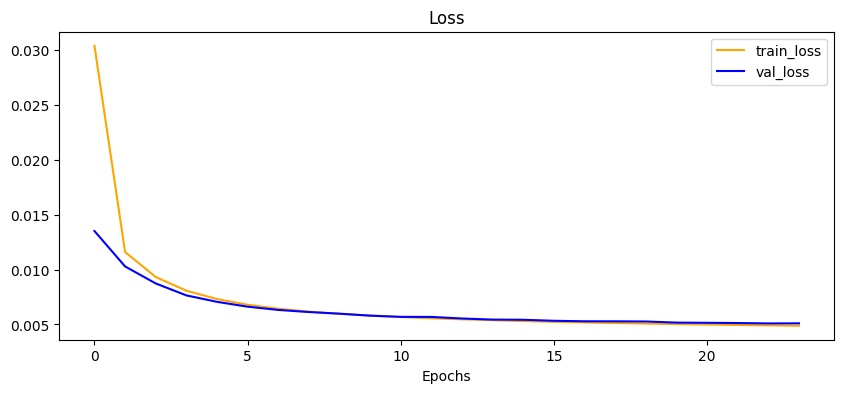

In [51]:
visualize_results_gdl(results)

## Reconstructing some images

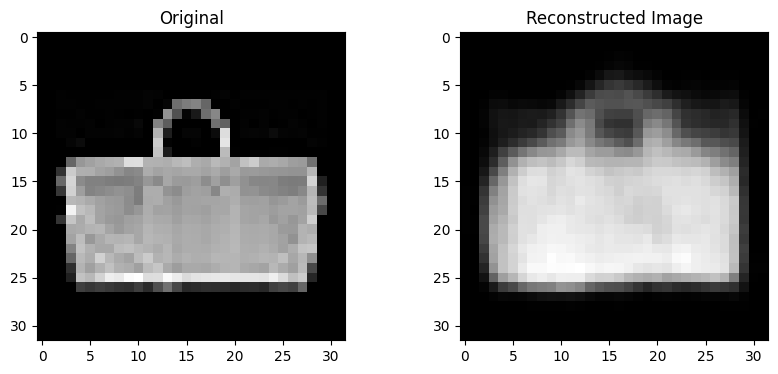

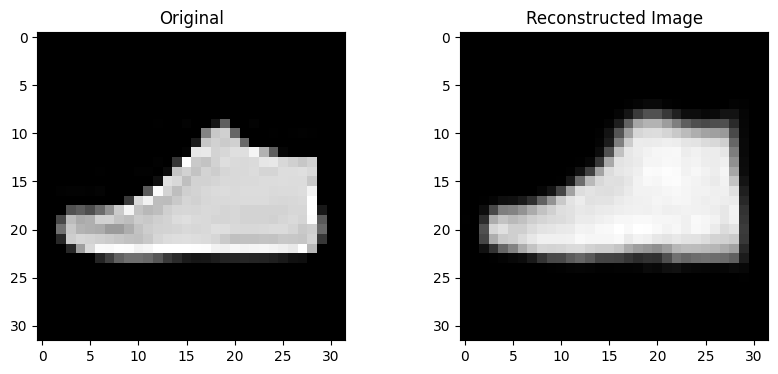

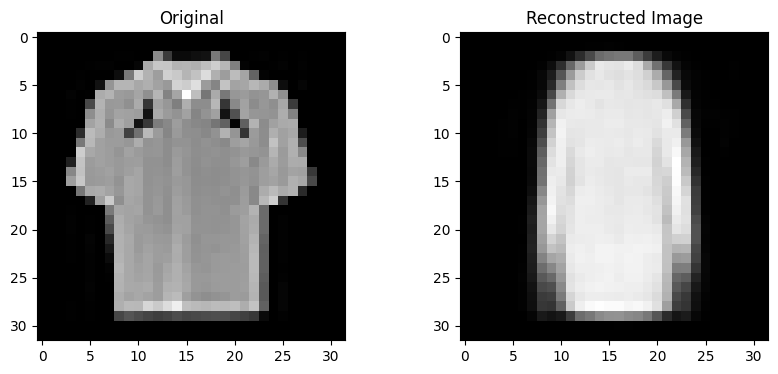

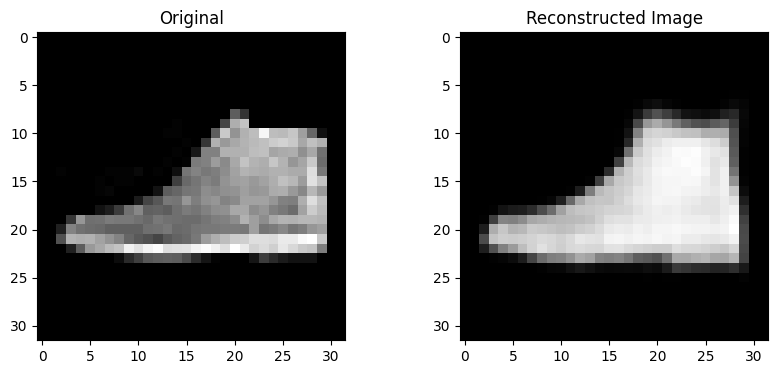

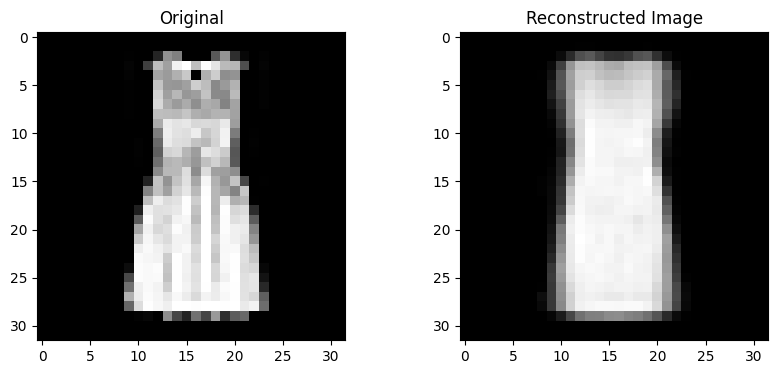

In [52]:
def fn():
    idx = 0
    for X,y in test_loader:
        if idx == 5:
            break
        X = X.to(DEVICE)
        img = X[idx].unsqueeze(dim=0)
        predict_torch_gdl(ae1, img, DEVICE)
        idx += 1
    pass

fn()

# Building a classifier by freezing encoder's weights

In [53]:
class Classifier1(nn.Module):
    def __init__(self, model):
        super(Classifier1, self).__init__()
        self.encoder = copy.deepcopy(model.encoder)
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.classifier_head = nn.Sequential(
            nn.Linear(32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        latent_space_embedding = self.encoder(x)
        x = self.classifier_head(latent_space_embedding)
        return x
    

In [54]:
def fn():
    model = Classifier1(ae2).to(DEVICE)
    return summary(model=model, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Classifier1 (Classifier1)                [1, 1, 32, 32]       [1, 10]              --                   Partial
├─Encoder2 (encoder)                     [1, 1, 32, 32]       [1, 32]              --                   False
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      (320)                False
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        (18,496)             False
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       (73,856)             False
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatte

In [55]:
def fn():
    model = Classifier1(ae2).to(DEVICE)
    for X, y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        pred = torch.softmax(model(X), dim=1).argmax(dim=1)
        print(pred[0], y[0], sep='\n')
        break
    
fn()

tensor(6, device='cuda:0')
tensor(8, device='cuda:0')


In [56]:
classifier_model1 = Classifier1(ae2).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=classifier_model1.parameters(), lr=3e-4)

results = training_fn(model=classifier_model1, train_loader=train_loader, val_loader=val_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=24, device=DEVICE)

  4%|▍         | 1/24 [00:03<01:20,  3.51s/it]

Epoch: 1 | Train_loss: 0.40363 | Train_acc: 0.85123 | Val_loss: 0.36881 | Val_acc: 0.86452


  8%|▊         | 2/24 [00:06<01:14,  3.39s/it]

Epoch: 2 | Train_loss: 0.30516 | Train_acc: 0.88608 | Val_loss: 0.32942 | Val_acc: 0.87994


 12%|█▎        | 3/24 [00:10<01:10,  3.37s/it]

Epoch: 3 | Train_loss: 0.27582 | Train_acc: 0.89641 | Val_loss: 0.32511 | Val_acc: 0.87975


 17%|█▋        | 4/24 [00:13<01:07,  3.36s/it]

Epoch: 4 | Train_loss: 0.25563 | Train_acc: 0.90407 | Val_loss: 0.30233 | Val_acc: 0.88667


 21%|██        | 5/24 [00:16<01:03,  3.34s/it]

Epoch: 5 | Train_loss: 0.23731 | Train_acc: 0.91013 | Val_loss: 0.29740 | Val_acc: 0.89517


 25%|██▌       | 6/24 [00:20<01:00,  3.34s/it]

Epoch: 6 | Train_loss: 0.22205 | Train_acc: 0.91601 | Val_loss: 0.30517 | Val_acc: 0.88746


 29%|██▉       | 7/24 [00:23<00:56,  3.32s/it]

Epoch: 7 | Train_loss: 0.20779 | Train_acc: 0.92128 | Val_loss: 0.30297 | Val_acc: 0.88904


 33%|███▎      | 8/24 [00:26<00:53,  3.34s/it]

Epoch: 8 | Train_loss: 0.19446 | Train_acc: 0.92656 | Val_loss: 0.29996 | Val_acc: 0.89676


 38%|███▊      | 9/24 [00:30<00:50,  3.36s/it]

Epoch: 9 | Train_loss: 0.17986 | Train_acc: 0.93102 | Val_loss: 0.30874 | Val_acc: 0.89715


 42%|████▏     | 10/24 [00:33<00:47,  3.40s/it]

Epoch: 10 | Train_loss: 0.16709 | Train_acc: 0.93608 | Val_loss: 0.30662 | Val_acc: 0.90032


 46%|████▌     | 11/24 [00:37<00:44,  3.39s/it]

Epoch: 11 | Train_loss: 0.15411 | Train_acc: 0.94211 | Val_loss: 0.30600 | Val_acc: 0.89992


 50%|█████     | 12/24 [00:40<00:40,  3.37s/it]

Epoch: 12 | Train_loss: 0.14098 | Train_acc: 0.94578 | Val_loss: 0.31496 | Val_acc: 0.89577


 54%|█████▍    | 13/24 [00:43<00:36,  3.36s/it]

Epoch: 13 | Train_loss: 0.12823 | Train_acc: 0.95119 | Val_loss: 0.34176 | Val_acc: 0.89339


 58%|█████▊    | 14/24 [00:47<00:33,  3.35s/it]

Epoch: 14 | Train_loss: 0.11753 | Train_acc: 0.95476 | Val_loss: 0.34181 | Val_acc: 0.89972


 62%|██████▎   | 15/24 [00:50<00:30,  3.35s/it]

Epoch: 15 | Train_loss: 0.10731 | Train_acc: 0.95934 | Val_loss: 0.36083 | Val_acc: 0.89775


 67%|██████▋   | 16/24 [00:53<00:26,  3.36s/it]

Epoch: 16 | Train_loss: 0.09502 | Train_acc: 0.96372 | Val_loss: 0.38465 | Val_acc: 0.89438


 71%|███████   | 17/24 [00:57<00:23,  3.34s/it]

Epoch: 17 | Train_loss: 0.08505 | Train_acc: 0.96737 | Val_loss: 0.39669 | Val_acc: 0.89676


 75%|███████▌  | 18/24 [01:00<00:20,  3.36s/it]

Epoch: 18 | Train_loss: 0.07727 | Train_acc: 0.97042 | Val_loss: 0.40265 | Val_acc: 0.89755


 79%|███████▉  | 19/24 [01:03<00:16,  3.37s/it]

Epoch: 19 | Train_loss: 0.06915 | Train_acc: 0.97343 | Val_loss: 0.43789 | Val_acc: 0.89873


 83%|████████▎ | 20/24 [01:07<00:13,  3.35s/it]

Epoch: 20 | Train_loss: 0.06263 | Train_acc: 0.97701 | Val_loss: 0.45673 | Val_acc: 0.89320


 88%|████████▊ | 21/24 [01:10<00:10,  3.36s/it]

Epoch: 21 | Train_loss: 0.05959 | Train_acc: 0.97735 | Val_loss: 0.45699 | Val_acc: 0.89992


 92%|█████████▏| 22/24 [01:13<00:06,  3.35s/it]

Epoch: 22 | Train_loss: 0.04902 | Train_acc: 0.98193 | Val_loss: 0.49423 | Val_acc: 0.90012


 96%|█████████▌| 23/24 [01:17<00:03,  3.34s/it]

Epoch: 23 | Train_loss: 0.04716 | Train_acc: 0.98299 | Val_loss: 0.52238 | Val_acc: 0.89438


100%|██████████| 24/24 [01:20<00:00,  3.36s/it]

Epoch: 24 | Train_loss: 0.04465 | Train_acc: 0.98354 | Val_loss: 0.52646 | Val_acc: 0.89577


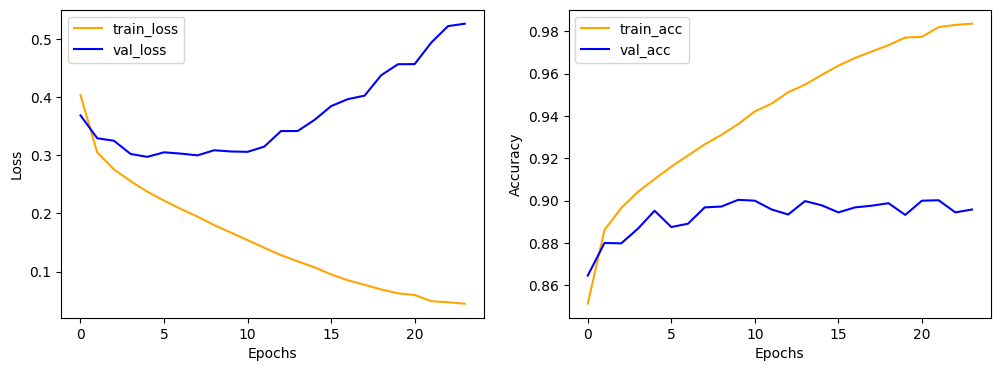

In [57]:
visualize_results(results)

## Making some prediction using the classifier

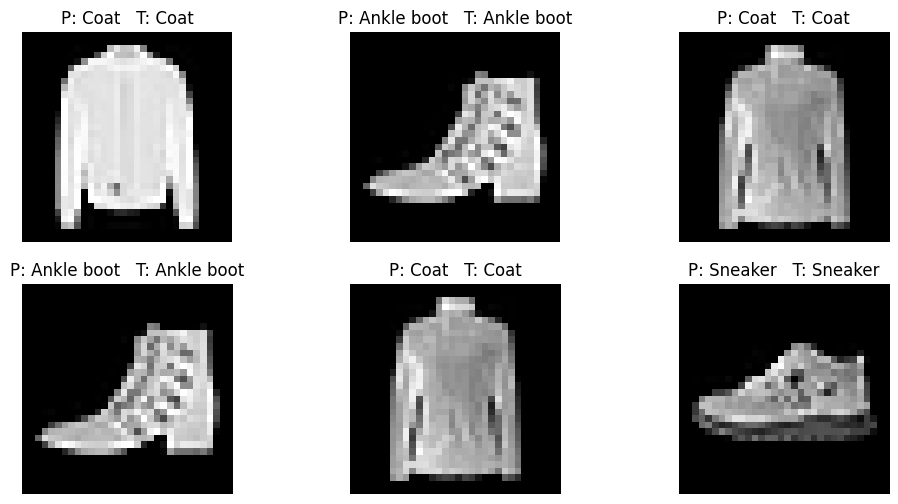

In [64]:
def predict_classifier(model, device):
    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            preds = torch.softmax(model(X), dim=1).argmax(dim=1)
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    preds = preds.squeeze(axis=0).cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    X = X.cpu().detach().numpy()
    for i in range(2):
        for j in range(3):
            pred_label = class_labels[preds[i+j]]
            y_label = class_labels[y[i+j]]
            ax[i,j].set_title(f"P: {pred_label}   T: {y_label}")
            ax[i,j].imshow(X[i+j].squeeze(axis=0), cmap="gray")
            ax[i,j].axis("off")
    pass


predict_classifier(classifier_model1, DEVICE)